### Инициализация и настройки

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset as TorchDataset

# Настройки для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Определение алфавита

In [7]:
# Русские буквы, цифры и специальные символы
RUSSIAN_LETTERS = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
DIGITS = '0123456789'
SPECIAL_CHARS = ' !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»№'
LATIN_LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Полный алфавит
alphabet = ''.join(sorted(set(
    RUSSIAN_LETTERS + DIGITS + SPECIAL_CHARS + LATIN_LETTERS
), key=(RUSSIAN_LETTERS + DIGITS + SPECIAL_CHARS + LATIN_LETTERS).index))

num_classes = len(alphabet) + 1  # +1 для blank символа CTC
print(f"Размер алфавита: {len(alphabet)}")
print(f"Алфавит: {alphabet}")

Размер алфавита: 105
Алфавит: АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»№ABCDEFGHIJKLMNOPQRSTUVWXYZ


### Класс датасет

In [8]:
class ImageTextDataset(TorchDataset):
    def __init__(self, data):
        self.data = data
        # Находим максимальную ширину во всем датасете
        self.max_width = max(np.array(sample['image']).shape[2] for sample in data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # Конвертируем в numpy array и убираем лишние размерности
        img = np.array(sample['image']).squeeze()
        text = sample['text']
        
        # Дополняем изображение до максимальной ширины
        pad_width = self.max_width - img.shape[1]
        if pad_width > 0:
            img = np.pad(img, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
            
        return {
            'image': torch.from_numpy(img).unsqueeze(0).float(),  # Добавляем размерность канала
            'text': text
        }

def save_datasets(dataset_dict, save_dir="preprocessed_data"):
    """Сохраняет датасеты в формате HuggingFace"""
    os.makedirs(save_dir, exist_ok=True)
    
    for split in dataset_dict.keys():
        # Сохраняем в родном формате HuggingFace
        dataset_dict[split].save_to_disk(os.path.join(save_dir, split))
    
    print(f"Датасеты сохранены в {save_dir}")

def load_datasets(save_dir="preprocessed_data"):
    """Загружает датасеты из сохраненного формата"""
    from datasets import DatasetDict, load_from_disk
    
    datasets = {}
    
    for split in ['train', 'test']:
        split_dir = os.path.join(save_dir, split)
        if os.path.exists(split_dir):
            datasets[split] = load_from_disk(split_dir)
    
    # Конвертируем в PyTorch Dataset
    torch_datasets = {
        split: ImageTextDataset(datasets[split])
        for split in datasets.keys()
    }
    
    print(f"Загружено {len(torch_datasets.get('train', []))} train и {len(torch_datasets.get('test', []))} test примеров")
    return torch_datasets

def collate_fn(batch):
    """Обрабатывает батчи с изображениями разного размера"""
    max_width = max(item['image'].shape[2] for item in batch)
    
    images = []
    texts = []
    for item in batch:
        img = item['image']
        pad = max_width - img.shape[2]
        if pad > 0:
            img = torch.nn.functional.pad(img, (0, pad))
        images.append(img)
        texts.append(item['text'])
    
    return {
        'image': torch.stack(images),
        'text': texts
    }

### Загрузка данных

In [9]:
def collate_fn(batch):
    """Обработка батча с разной шириной изображений"""
    images = [item['image'] for item in batch]
    texts = [item['text'] for item in batch]
    
    # Выравнивание по максимальной ширине
    max_width = max(img.shape[2] for img in images)
    padded_images = []
    for img in images:
        pad = max_width - img.shape[2]
        if pad > 0:
            img = torch.nn.functional.pad(img, (0, pad))
        padded_images.append(img)
    
    # Подготовка таргетов
    max_text_len = max(len(text) for text in texts)
    targets = torch.full((len(texts), max_text_len), num_classes-1, dtype=torch.long)
    for i, text in enumerate(texts):
        text = text.upper()
        for j, char in enumerate(text):
            if char in alphabet:
                targets[i,j] = alphabet.index(char)
    
    return {
        'image': torch.stack(padded_images),
        'text': texts,
        'targets': targets
    }

def load_datasets(save_dir="preprocessed_data"):
    """Загружает датасеты из сохраненного формата"""
    from datasets import DatasetDict, load_from_disk
    
    datasets = {}
    
    for split in ['train', 'test']:
        split_dir = os.path.join(save_dir, split)
        if os.path.exists(split_dir):
            datasets[split] = load_from_disk(split_dir)
    
    # Конвертируем в PyTorch Dataset
    torch_datasets = {
        split: ImageTextDataset(datasets[split])
        for split in datasets.keys()
    }
    
    print(f"Загружено {len(torch_datasets.get('train', []))} train и {len(torch_datasets.get('test', []))} test примеров")
    return torch_datasets

# Загрузка данных
torch_datasets = load_datasets()
print(f"Train samples: {len(torch_datasets['train'])}, Test samples: {len(torch_datasets['test'])}")

Загружено 72284 train и 1544 test примеров
Train samples: 72284, Test samples: 1544


### Визуализация данных

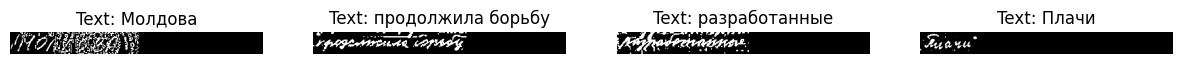

In [10]:
# Проверка данных
sample_batch = next(iter(DataLoader(torch_datasets['train'], batch_size=4, collate_fn=collate_fn)))

plt.figure(figsize=(15, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_batch['image'][i].squeeze().numpy(), cmap='gray')
    plt.title(f"Text: {sample_batch['text'][i]}")
    plt.axis('off')
plt.show()

### Архитектура CRNN

In [11]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            
            nn.Conv2d(512, 512, 2, stride=1),
            nn.ReLU()
        )
        
        self.lstm = nn.LSTM(512, 256, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # CNN
        x = self.cnn(x)
        
        # Подготовка для RNN
        x = x.squeeze(2)  # [B, C, W]
        x = x.permute(2, 0, 1)  # [W, B, C]
        
        # RNN
        x, _ = self.lstm(x)
        
        # Классификатор
        x = self.fc(x)
        return x

###  Вспомогательные функции

In [12]:
def decode_predictions(preds, alphabet):
    """Декодирование предсказаний модели в текст"""
    preds = preds.permute(1, 0, 2)  # (batch, seq_len, num_classes)
    preds = torch.softmax(preds, dim=2)
    preds = torch.argmax(preds, dim=2)
    
    texts = []
    for pred in preds.cpu().numpy():
        text = []
        prev_char = None
        for char_idx in pred:
            if char_idx != len(alphabet):  # Игнорируем blank
                char = alphabet[char_idx]
                if char != prev_char:  # Удаляем повторы
                    text.append(char)
                    prev_char = char
        texts.append(''.join(text))
    return texts

def calculate_accuracy(preds, texts, alphabet):
    """Вычисление accuracy по частичному совпадению"""
    decoded_preds = decode_predictions(preds, alphabet)
    correct = 0
    
    for pred, true_text in zip(decoded_preds, texts):
        true_text = true_text.upper()
        if len(pred) > 0 and any(c in true_text for c in pred):
            correct += 1
    
    return correct / len(decoded_preds)

### Инициализация модели и DataLoader

In [16]:
# Инициализация модели
model = CRNN(img_height=32, num_channels=1, num_classes=num_classes).to(device)

# DataLoader
train_loader = DataLoader(
    torch_datasets['train'],
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    torch_datasets['test'],
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=num_classes-1, zero_infinity=True).to(device)

### Функции обучения и валидации

In [17]:
def train_epoch(model, loader, optimizer, criterion, alphabet, device):
    model.train()
    total_loss = 0
    total_acc = 0
    
    for batch in tqdm(loader, desc="Training"):
        images = batch['image'].to(device)
        texts = batch['text']
        
        # Forward pass
        optimizer.zero_grad()
        preds = model(images)
        
        # Подготовка таргетов для CTC
        input_lengths = torch.full((preds.size(1),), preds.size(0), dtype=torch.long)
        target_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
        
        # Расчет потерь
        loss = criterion(
            preds.log_softmax(2),
            batch['targets'].to(device),
            input_lengths.to(device),
            target_lengths.to(device)
        )
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Расчет accuracy
        acc = calculate_accuracy(preds, texts, alphabet)
        
        total_loss += loss.item()
        total_acc += acc
    
    return total_loss / len(loader), total_acc / len(loader)

def validate(model, loader, criterion, alphabet, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            images = batch['image'].to(device)
            texts = batch['text']
            
            preds = model(images)
            
            input_lengths = torch.full((preds.size(1),), preds.size(0), dtype=torch.long)
            target_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
            
            loss = criterion(
                preds.log_softmax(2),
                batch['targets'].to(device),
                input_lengths.to(device),
                target_lengths.to(device)
            )
            
            acc = calculate_accuracy(preds, texts, alphabet)
            
            total_loss += loss.item()
            total_acc += acc
    
    return total_loss / len(loader), total_acc / len(loader)

### Обучение модели

In [18]:
# История обучения
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, alphabet, device
    )
    val_loss, val_acc = validate(
        model, test_loader, criterion, alphabet, device
    )
    
    # Сохранение истории
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Вывод результатов
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Пример предсказаний
    with torch.no_grad():
        sample = next(iter(test_loader))
        sample_preds = model(sample['image'][:3].to(device))
        print("\nПримеры предсказаний:")
        for i in range(3):
            print(f"True: '{sample['text'][i]}'")
            print(f"Pred: '{decode_predictions(sample_preds, alphabet)[i]}'\n")

Validation: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]



Epoch 1/10
Train Loss: 3.6445 | Train Acc: 0.0453
Val Loss: 3.5192 | Val Acc: 0.4462

Примеры предсказаний:
True: 'ибо'
Pred: ''

True: 'осталось'
Pred: 'П'

True: 'поле'
Pred: ''



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]



Epoch 2/10
Train Loss: 3.2256 | Train Acc: 0.6055
Val Loss: 3.2203 | Val Acc: 0.6763

Примеры предсказаний:
True: 'ибо'
Pred: ''

True: 'осталось'
Pred: 'СО'

True: 'поле'
Pred: 'НА'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]



Epoch 3/10
Train Loss: 2.4543 | Train Acc: 0.8519
Val Loss: 2.2544 | Val Acc: 0.9731

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАТОЬ'

True: 'поле'
Pred: 'ПОГ'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]



Epoch 4/10
Train Loss: 1.4521 | Train Acc: 0.9782
Val Loss: 1.6672 | Val Acc: 0.9850

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОЬ'

True: 'поле'
Pred: 'ПОЕ'



Validation: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]



Epoch 5/10
Train Loss: 1.0072 | Train Acc: 0.9906
Val Loss: 1.4739 | Val Acc: 0.9906

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОСО'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]



Epoch 6/10
Train Loss: 0.8074 | Train Acc: 0.9940
Val Loss: 1.3530 | Val Acc: 0.9938

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОЛО'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]



Epoch 7/10
Train Loss: 0.6782 | Train Acc: 0.9953
Val Loss: 1.3285 | Val Acc: 0.9894

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОЛЕ'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.27it/s]



Epoch 8/10
Train Loss: 0.5807 | Train Acc: 0.9968
Val Loss: 1.3055 | Val Acc: 0.9912

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОЛО'



Validation: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]



Epoch 9/10
Train Loss: 0.5031 | Train Acc: 0.9973
Val Loss: 1.2799 | Val Acc: 0.9975

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОГО'



Validation: 100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


Epoch 10/10
Train Loss: 0.4400 | Train Acc: 0.9980
Val Loss: 1.2890 | Val Acc: 0.9900

Примеры предсказаний:
True: 'ибо'
Pred: 'ИБО'

True: 'осталось'
Pred: 'ОСТАЛОСЬ'

True: 'поле'
Pred: 'ПОЛО'



### Сохранение модели

In [20]:
torch.save({
    'model': model.state_dict(),
    'alphabet': alphabet,
    'optimizer': optimizer.state_dict()
}, 'best_crnn.pth')

### Визуализация результатов

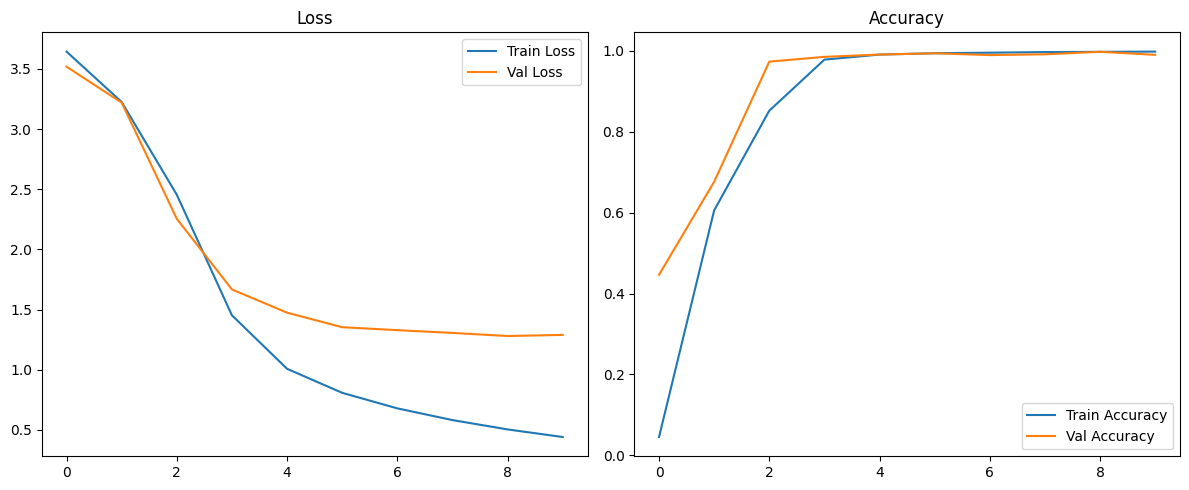

In [19]:
# Графики обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()